In [1]:
import pandas as pd
import numpy as np

## CLQ

In [12]:
nestab = pd.read_stata("NESTAB_SHARES.dta")
nestab.columns = ["cfips", "year", "manfirm_it", "manfirm_it_ipolate", "manfirm_t", "manfirm_share_it"]

In [13]:
auto = pd.read_stata("demography_company4_time_series_inc_county_ids_data_long_exc_missing_vpreliminary.dta")
auto = auto.groupby(["cfips", "year"])[["a"]].sum().reset_index()

total_auto = auto.groupby("year").sum()["a"].reset_index()
total_auto.columns = ["year", "totala"]
auto = auto.merge(total_auto, "left", "year")
auto.columns = ["cfips", "year", "autofirms_it", "autofirms_t"]
auto = auto.merge(nestab, "left", ["year", "cfips"])
auto["clq_it"] = auto["autofirms_it"]/(auto["manfirm_share_it"]*auto["autofirms_t"]) #INDICE --> CONFIRMAS CON XAVIER


In [ ]:
#Este dataset queda de 7704 porque el dataset que tiene los autofirms_it es de 7704

In [51]:
# auto[auto.clq.notna()].sort_values("clq", ascending = False).head(30)

<AxesSubplot:xlabel='year'>

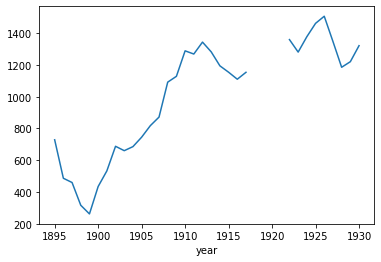

In [52]:
auto.groupby(["year"])["clq"].sum().plot()

In [67]:
auto.to_excel("clq.xlsx", index = False)

<ipython-input-67-996aca921c2f>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  auto.to_excel("clq.xlsx", index = False)


## RLQ

In [18]:
nestab = nestab[nestab.manfirm_share_it>0]
nestab["nestabs"] = (nestab["manfirm_share_it"]*100000).astype(int)

<ipython-input-18-2b8628b7e9fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nestab["nestabs"] = (nestab["manfirm_share_it"]*100000).astype(int)


In [59]:
alive = [4, 7, 7, 12, 31, 60, 70, 100, 126, 126, 138, 166, 205, 220, 218, 207,193, 166, 157, 139, 138, 143, 124, 119, 127, 138, 138, 109, 74, 55, 46, 38, 36, 29, 27, 27]
alive = pd.DataFrame(zip(range(1895, 1931), alive), columns = ["year", "alive"])

In [20]:
percentil = 0.9

In [61]:
from tqdm import tqdm as tq

In [62]:
rlq = pd.DataFrame()

for año,vivos in tq(zip(alive.year[0:], alive.alive[0:])):

    p = nestab[nestab.year==año]
    p_expanded = p.loc[p.index.repeat(p.nestabs)].reset_index(drop=True)
    p_expanded = p_expanded[["cfips"]]

    alocaciones = len(p_expanded)

    # for i in range(0,1000):
    #     zero_positions = np.random.choice(alocaciones, vivos, replace=False)
    #     p_expanded[f'allocation_{i}'] = 0
    #     p_expanded.loc[zero_positions, f'allocation_{i}'] = 1

    
     # Preparar un contenedor para las nuevas columnas (usando un diccionario en este caso)
    new_columns = {}

    for i in range(0, 1000):
        zero_positions = np.random.choice(alocaciones, vivos, replace=False)
        new_column_data = np.zeros(alocaciones)
        new_column_data[zero_positions] = 1
        new_columns[f'allocation_{i}'] = new_column_data

    
    new_columns_df = pd.DataFrame(new_columns) # Convertir el diccionario en un DataFrame
    p_expanded = pd.concat([p_expanded, new_columns_df], axis=1)  # Concatenar con el DataFrame original

    
    p_grouped = p_expanded.groupby("cfips").sum()

    p_grouped_tile = p_grouped.T.quantile(percentil).reset_index()

    p_grouped_tile.columns = ["cfips", f"p{int(percentil*100)}"]

    p_grouped_tile["year"] = año

    rlq = pd.concat([rlq, p_grouped_tile], axis = 0)

36it [04:53,  8.15s/it]


In [63]:
rlqf = rlq.merge(auto[["cfips", "year", "autofirms_it"]], "left", ["cfips", "year"]).fillna(0)

In [64]:
rlqf["rlq_it"] = rlqf["autofirms_it"]/rlqf["p90"]

<AxesSubplot:xlabel='year'>

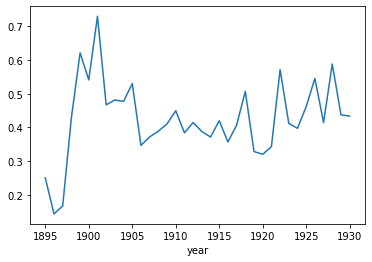

In [65]:
rlqf[(rlqf.rlq_it.notna()) & (rlqf.rlq_it!=np.inf)].groupby(["year"])["rlq_it"].mean().plot()

In [66]:
rlqf.to_excel("rlq.xlsx", index = False)

<ipython-input-66-944b0c8832b2>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  rlqf.to_excel("rlq.xlsx", index = False)


## PEGUE

In [2]:
import pandas as pd

In [3]:
dlq = pd.read_stata("COPB3_ESTATICO (ELQ).dta")

In [6]:
dlq = dlq[["year", "cfips", "copB2_3"]]

In [7]:
rlqf = pd.read_excel("rlq.xlsx")

In [8]:
auto = pd.read_excel("clq.xlsx")

In [16]:
dff = pd.merge(dlq, auto, "outer", ["cfips", "year"])
dff = pd.merge(dff, rlqf, "outer", ["cfips", "year"])

In [17]:
dff = dff[["year", "cfips", "copB2_3", "clq_it", "rlq_it"]]
dff.to_excel("indices_compilation.xlsx", index = False)

<ipython-input-17-ecbdf3db4079>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  dff.to_excel("indices_compilation.xlsx", index = False)


In [18]:
dff

,year,cfips,copB2_3,clq_it,rlq_it
0,1908.0,18043.0,0.0,0.0,NaN
1,1925.0,13055.0,0.0,NaN,NaN
2,1910.0,47165.0,0.0,NaN,NaN
3,1920.0,29135.0,0.0,NaN,NaN
4,1910.0,31021.0,0.0,NaN,NaN
...,...,...,...,...,...
75839,1930.0,54057.0,NaN,NaN,NaN
75840,1930.0,54073.0,NaN,NaN,NaN
75841,1930.0,54079.0,NaN,NaN,NaN
75842,1930.0,54093.0,NaN,NaN,NaN
